# 📊 Exploratory Data Analysis (EDA) — Churn Dataset

# 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import sys
import warnings
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

# 2. EDA Class Code

In [5]:
# 1. Set visual aesthetics for professional plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 2. Create class to execute Exploratory Data Analysis
class ChurnEDA:
    """
    A comprehensive EDA class for Binary Classification Churn Prediction.
    Designed to work with a YAML configuration file for scalability.
    """

    def __init__(self, config_path: str):
        """
        Initialize the EDA class by loading configuration.
        
        Args:
            config_path (str): Path to the YAML configuration file.
        """
        self.config = self._load_config(config_path)
        self.df = None
        
        # --- Parsing Configuration based on new yaml structure ---
        try:
            preprocess_config = self.config.get('preprocess', {})
            column_types = preprocess_config.get('column_types', {})
            
            self.target_col = column_types.get('target')
            self.id_col = column_types.get('id_column')
            
            # Use empty list defaults if keys are missing or None
            self.num_cols = column_types.get('numerical_features') or []
            self.cat_cols = column_types.get('categorical_features') or []
            self.date_cols = column_types.get('date_features') or []
            # self.cols_to_drop = column_types.get('features_to_drop') or [] 

            # Validation
            if not self.target_col:
                raise ValueError("Target column not defined in config (preprocess.column_types.target)")
                
        except AttributeError as e:
            print(f"Configuration structure error: {e}")
            sys.exit(1)

    def _load_config(self, path: str) -> dict:
        """Helper to load YAML config safely."""
        try:
            with open(path, 'r') as file:
                return yaml.safe_load(file)
        except Exception as e:
            print(f"Error loading config: {e}")
            sys.exit(1)

    def load_data(self, filename: str = None):
        """
        Loads data. Tries to construct path from config directories if filename provided,
        or uses full path.
        """
        try:
            # Initialize main dir
            main_dir = os.path.dirname(os.getcwd())
            # Construct path using config directory if just a filename is given
            if filename and not os.path.isabs(filename) and not os.path.exists(filename):
                raw_dir = self.config.get('directories', {}).get('raw_data_path', '')
                data_path = os.path.join(main_dir, raw_dir, filename)
            else:
                data_path = filename

            if not data_path:
                raise ValueError("No data path provided.")

            print(f"Loading data from: {data_path}")
            self.df = pd.read_csv(data_path)
            print(f"Data loaded successfully. Shape: {self.df.shape}")
            
            # Initial Drop based on config
            # cols_to_remove = [c for c in self.cols_to_drop if c in self.df.columns]
            
            # Optionally drop ID column from analysis dataframe to prevent noise, 
            # but keep it if you need it for tracking. Usually dropped for EDA/Modeling.
            if self.id_col and self.id_col in self.df.columns:
                print(f"Note: ID column '{self.id_col}' is present.")
                # Uncomment next line if you want to strictly remove ID from EDA
                # cols_to_remove.append(self.id_col)
            
            # if cols_to_remove:
            #     self.df.drop(columns=cols_to_remove, inplace=True)
            #     print(f"Dropped columns: {cols_to_remove}")
                
        except FileNotFoundError:
            print(f"File not found.")
            sys.exit(1)
        except Exception as e:
            print(f"Error loading data: {e}")
            sys.exit(1)

    def check_data_quality(self):
        """
        Checks for missing values, duplicates, and data types.
        """
        print("\n--- Data Quality Check ---")
        print(self.df.info())
        
        missing = self.df.isnull().sum()
        if missing.sum() > 0:
            print("\nMissing Values Detected:")
            print(missing[missing > 0])
        else:
            print("\nNo missing values detected.")

        duplicates = self.df.duplicated().sum()
        print(f"\nDuplicate Rows: {duplicates}")

    def analyze_target_distribution(self):
        """
        Analyzes the target variable (Churn).
        """
        if self.target_col not in self.df.columns:
            print(f"Target column {self.target_col} not found in dataframe.")
            return

        print(f"\n--- Target Distribution ({self.target_col}) ---")
        counts = self.df[self.target_col].value_counts()
        prop = self.df[self.target_col].value_counts(normalize=True)
        
        print(pd.DataFrame({'Count': counts, 'Proportion': prop}))

        plt.figure(figsize=(6, 4))
        sns.countplot(x=self.target_col, data=self.df, palette='viridis')
        plt.title(f'Distribution of Target: {self.target_col}')
        plt.show()

        # MLOps Insight
        minority_class_prop = prop.min()
        if minority_class_prop < 0.2:
            print(f"\n[ALERT] Severe Class Imbalance detected (Minority class < 20%).")
            imbalance_conf = self.config.get('preprocess', {}).get('imbalance', {})
            active_method = imbalance_conf.get('active_method', 'None')
            print(f"Configured Imbalance Strategy: {active_method}")

    def analyze_numerical_features(self):
        """
        Analyzes numerical features defined in config.
        """
        print("\n--- Numerical Feature Analysis ---")
        
        # Verify columns exist
        valid_cols = [c for c in self.num_cols if c in self.df.columns]
        
        if not valid_cols:
            print("No numerical features found from config list in the dataframe.")
            return

        for col in valid_cols:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Histogram
            sns.histplot(data=self.df, x=col, hue=self.target_col, kde=True, element="step", ax=axes[0])
            axes[0].set_title(f'Distribution of {col} by Churn')
            
            # Boxplot
            sns.boxplot(data=self.df, x=self.target_col, y=col, ax=axes[1])
            axes[1].set_title(f'{col} vs Churn (Outlier Check)')
            
            plt.tight_layout()
            plt.show()

    def analyze_categorical_features(self):
        """
        Analyzes categorical features defined in config.
        """
        print("\n--- Categorical Feature Analysis ---")
        
        valid_cols = [c for c in self.cat_cols if c in self.df.columns]
        
        if not valid_cols:
            print("No categorical features defined or found.")
            return

        for col in valid_cols:
            cross_tab = pd.crosstab(self.df[col], self.df[self.target_col], normalize='index')
            print(f"\nChurn Rate by {col}:")
            print(cross_tab)
            
            plt.figure(figsize=(10, 5))
            cross_tab.plot(kind='bar', stacked=True, color=['#2ecc71', '#e74c3c'], ax=plt.gca())
            plt.title(f'Churn Proportion by {col}')
            plt.ylabel('Proportion')
            plt.show()

    def correlation_analysis(self):
        """
        Computes correlation matrix for numerical features.
        """
        print("\n--- Correlation Analysis ---")
        valid_cols = [c for c in self.num_cols if c in self.df.columns]
        
        if len(valid_cols) < 2:
            print("Not enough numerical columns for correlation analysis.")
            return

        corr = self.df[valid_cols].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.show()
    
    def feature_importance(self):
        """
        Computes feature importance based on sklearn mutual_info_classif (KNN)
        """

        print("---- Feature Utility Score (Mutual Information) ----")

        # It will not be working for null features
        df_temp = self.df[self.num_cols + [self.target_col]].dropna()
        
        X = df_temp[self.num_cols]
        y = df_temp[self.target_col]
        
        # MI Score Calc.
        mi_scores = mutual_info_classif(X, y, random_state=42)
        mi_scores = pd.Series(mi_scores, name="MI Score", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        
        print(mi_scores)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
        plt.title("Mutual Information Scores (Best Pred.)")
        plt.xlabel("Score (Higher is Better)")
        plt.show()
        
        return mi_scores

# 3. Code Execution

In [6]:
# 1. Path Configuration
# Adjust paths as per your project structure
MAIN_PATH = os.path.dirname(os.getcwd())
CONFIG_PATH = os.path.join(MAIN_PATH,'configs/data_config.yaml')
DATA_PATH = 'dummy_dataset.csv'

# 2. Initialize Analysis
eda = ChurnEDA(CONFIG_PATH)

Loading data from: /Users/i.putra/Documents/BinaryClassProject/artifacts/data/raw/dummy_dataset.csv
Data loaded successfully. Shape: (15000, 29)
Note: ID column 'customer_id' is present.

--- Data Quality Check ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   is_churn        15000 non-null  int64  
 1   customer_id     15000 non-null  int64  
 2   partition_date  15000 non-null  object 
 3   feature_a       15000 non-null  float64
 4   feature_b       15000 non-null  float64
 5   feature_c       15000 non-null  float64
 6   feature_d       15000 non-null  float64
 7   feature_e       15000 non-null  float64
 8   feature_f       15000 non-null  float64
 9   feature_g       15000 non-null  float64
 10  feature_h       15000 non-null  float64
 11  feature_i       15000 non-null  float64
 12  feature_j       15000 non-null  float64
 

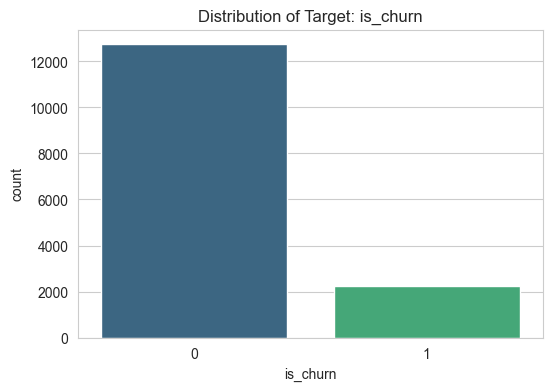


[ALERT] Severe Class Imbalance detected (Minority class < 20%).
Configured Imbalance Strategy: smote


In [7]:
# 3. Analysis I -- Target Distribution
eda.load_data(DATA_PATH)
eda.check_data_quality()
eda.analyze_target_distribution()


--- Numerical Feature Analysis ---


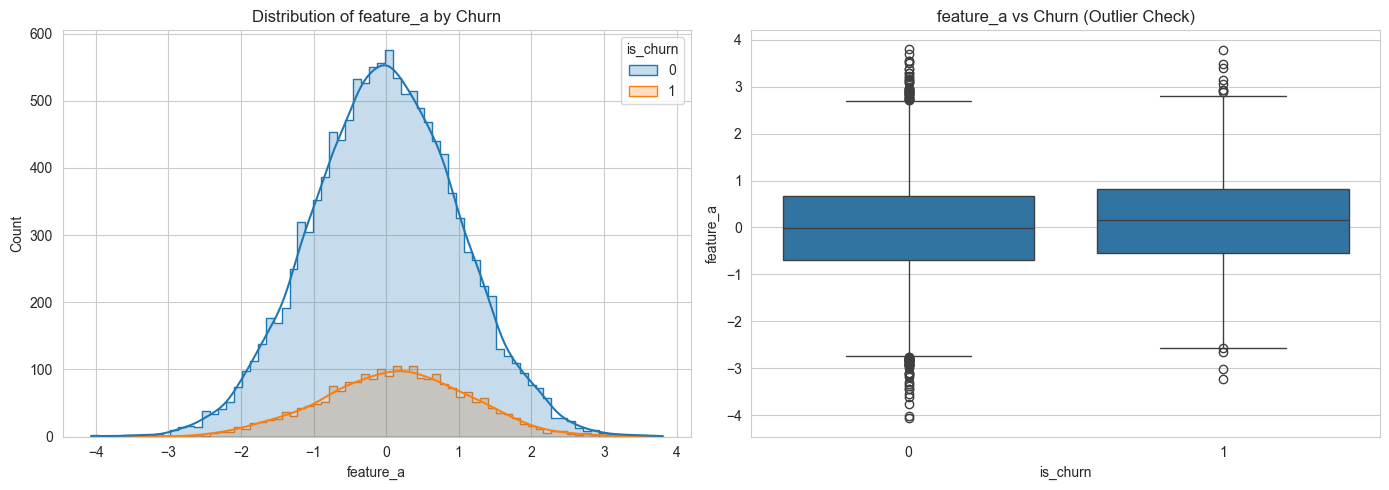

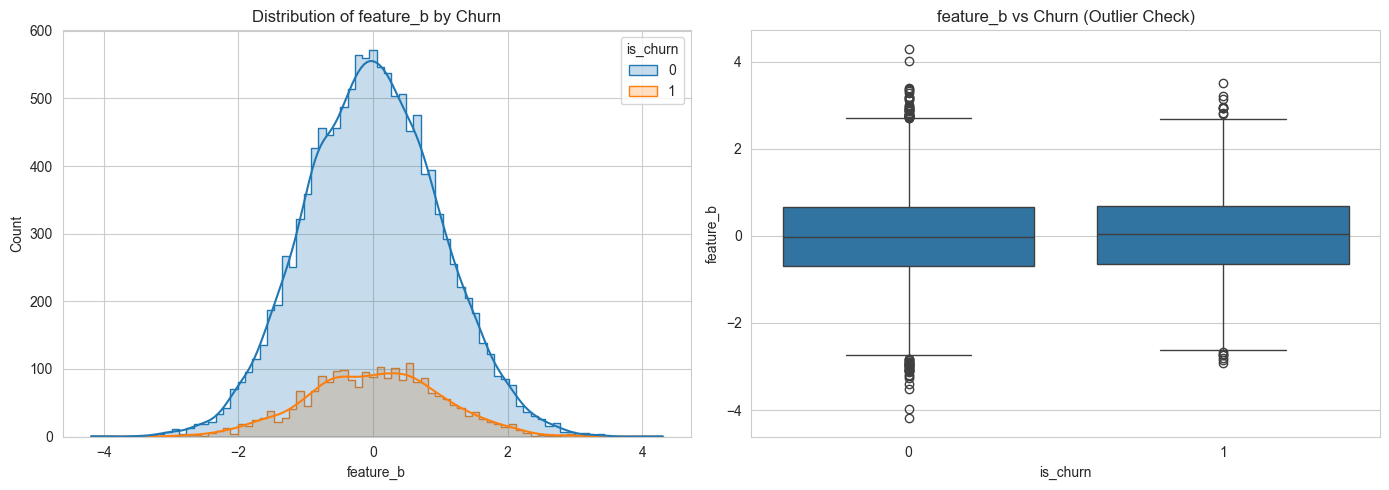

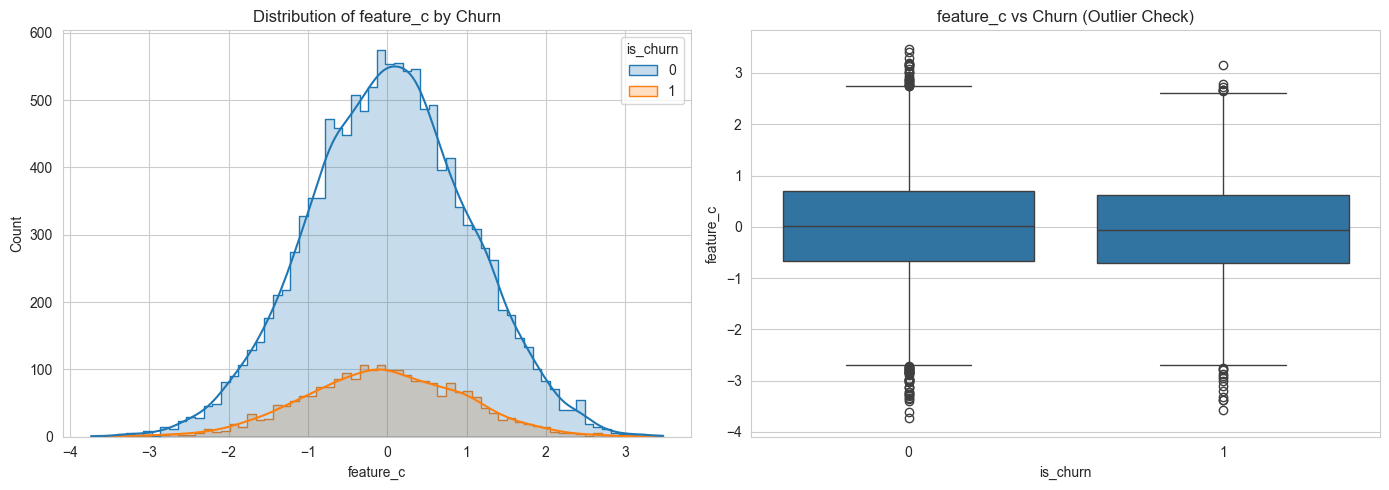

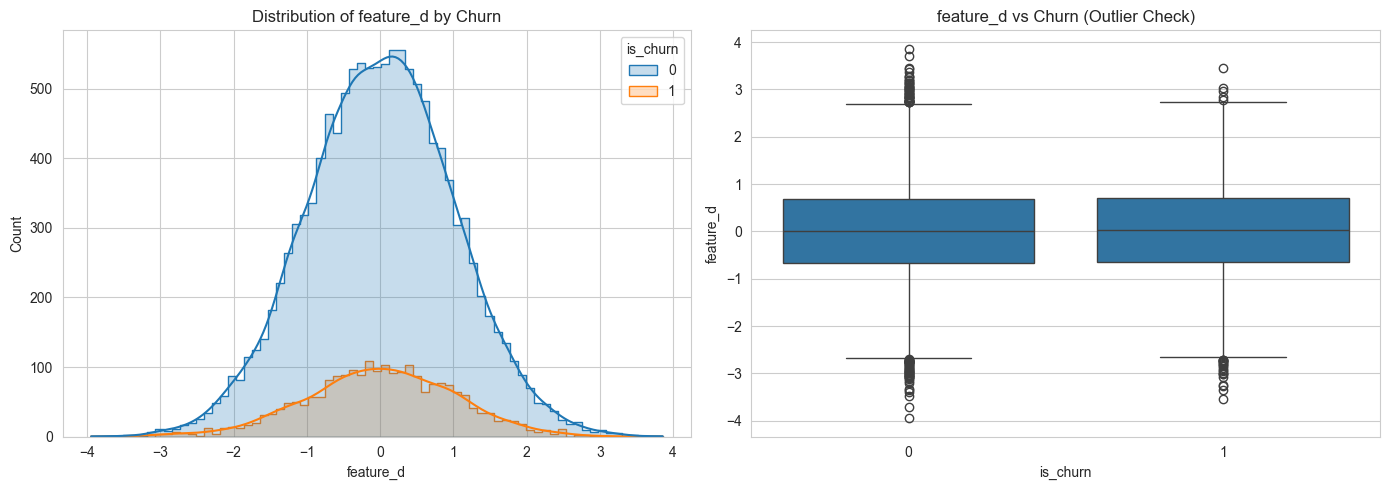

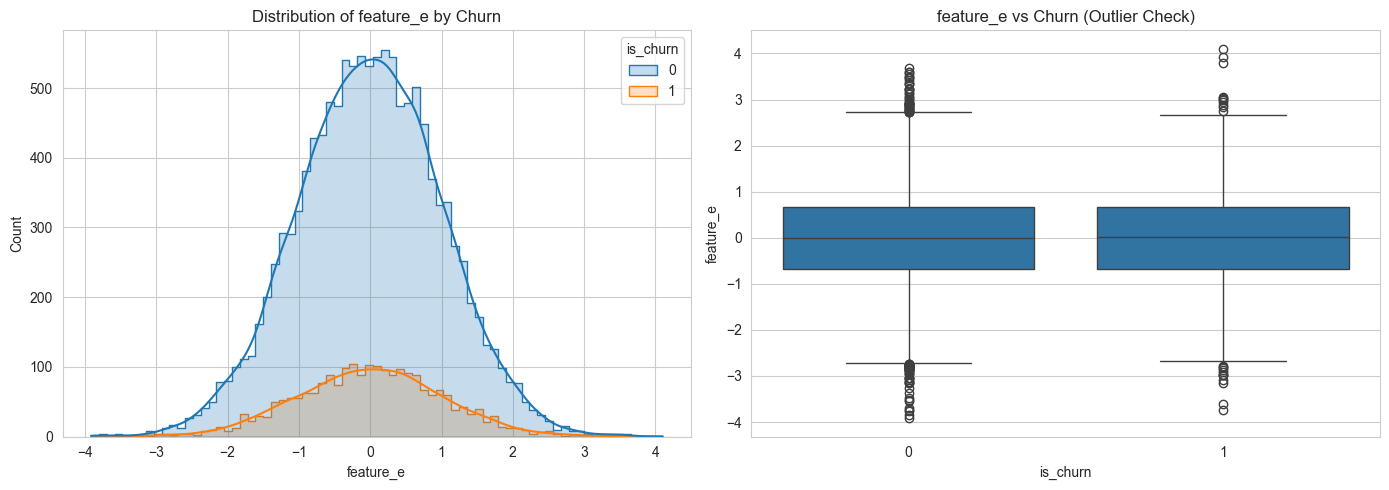

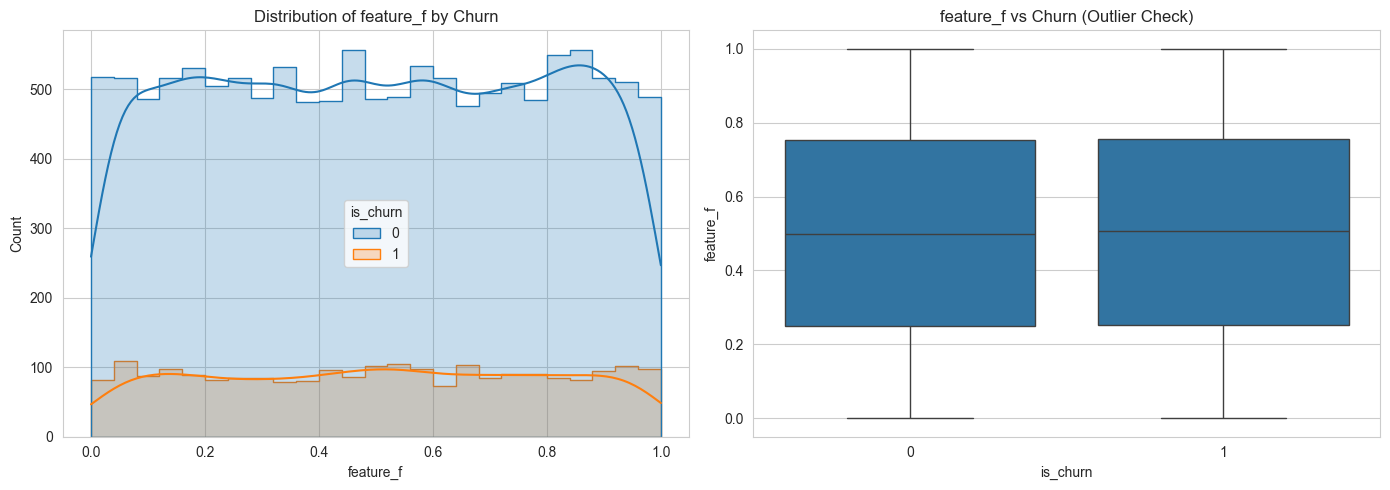

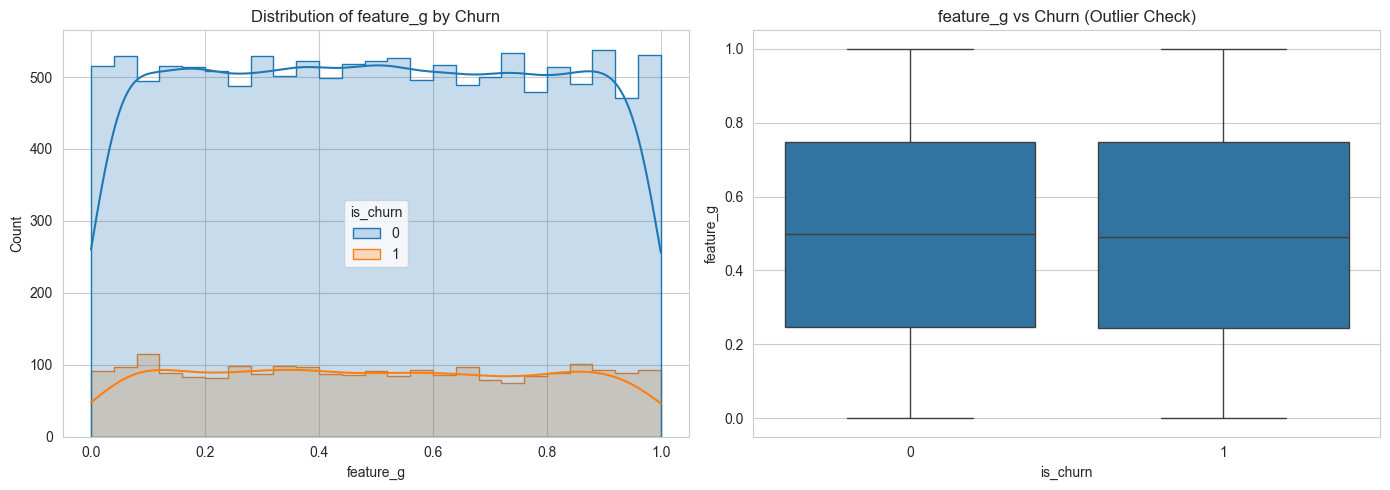

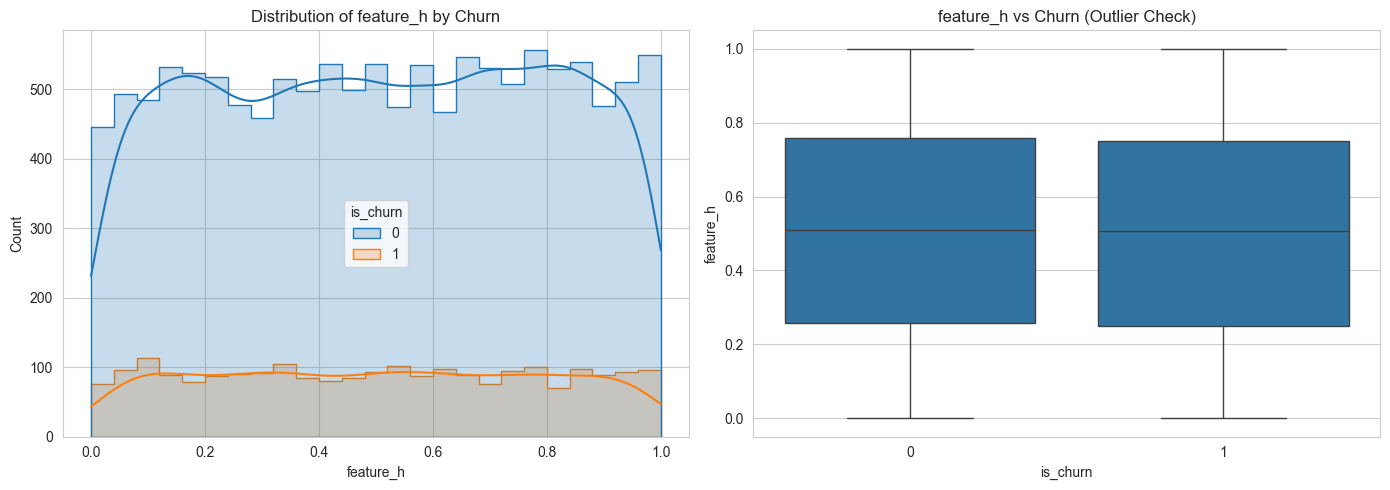

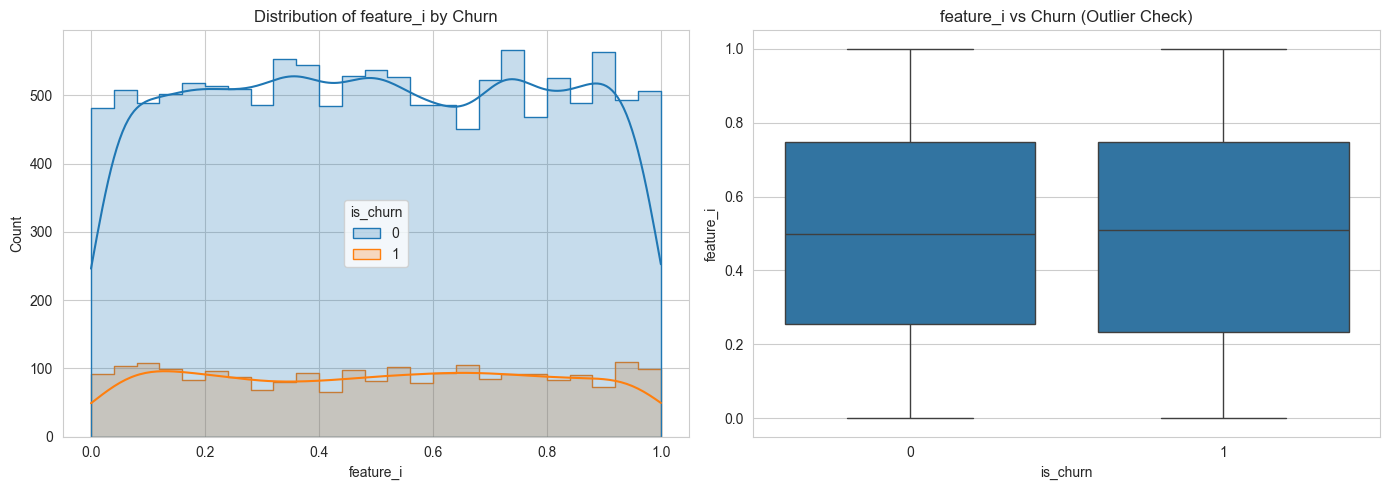

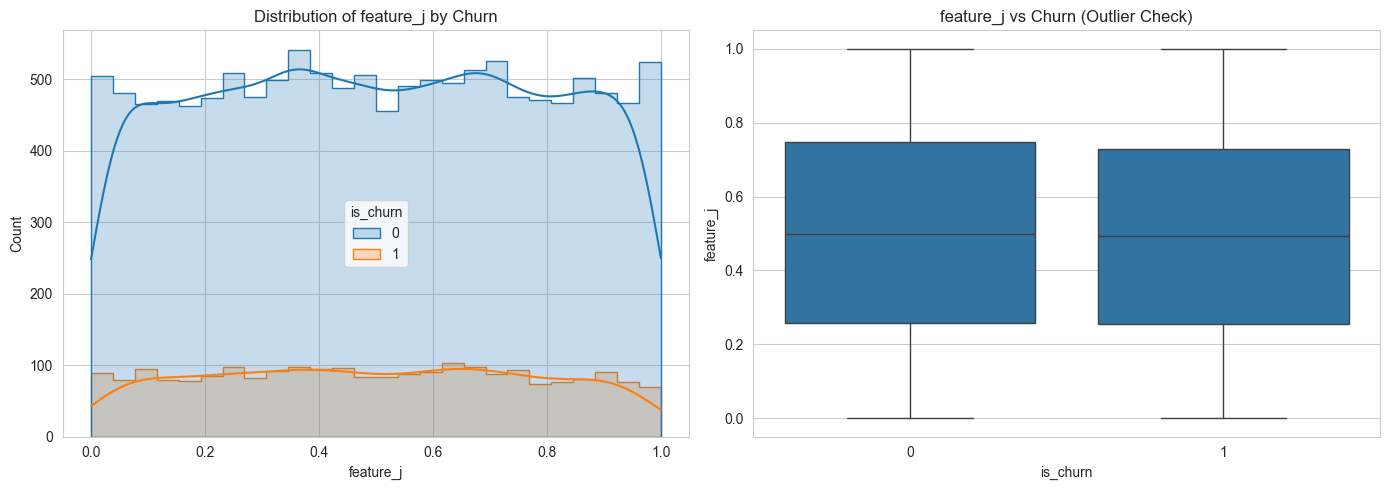

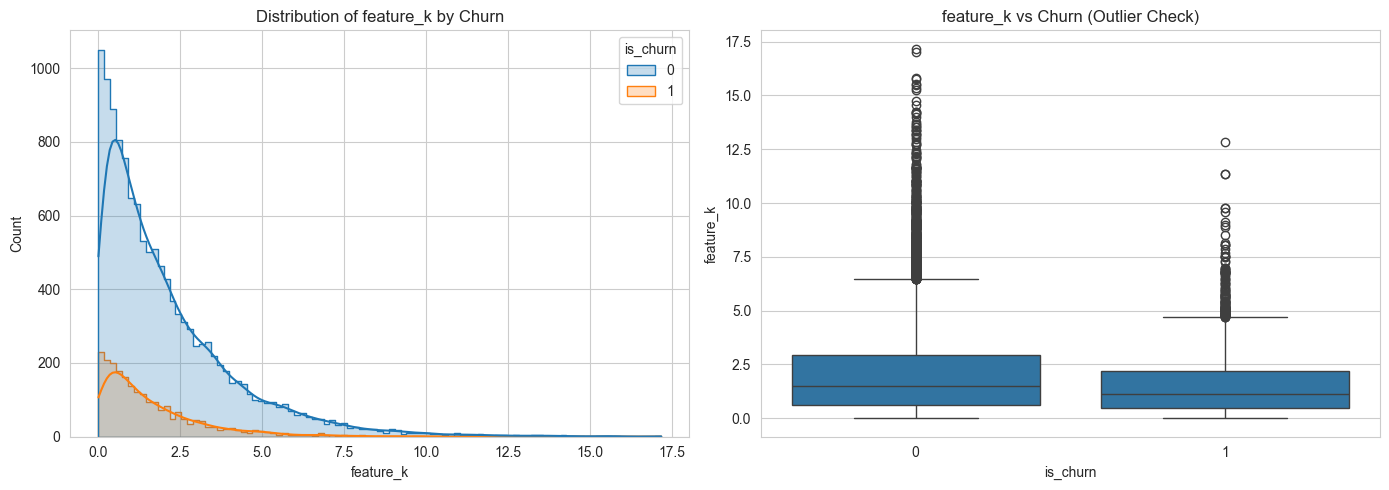

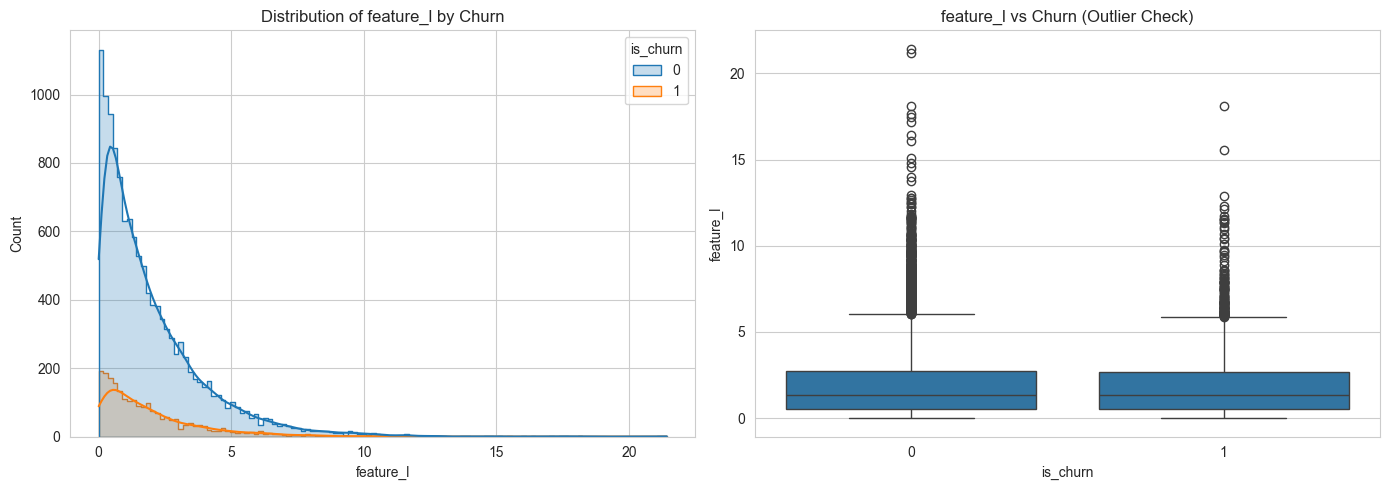

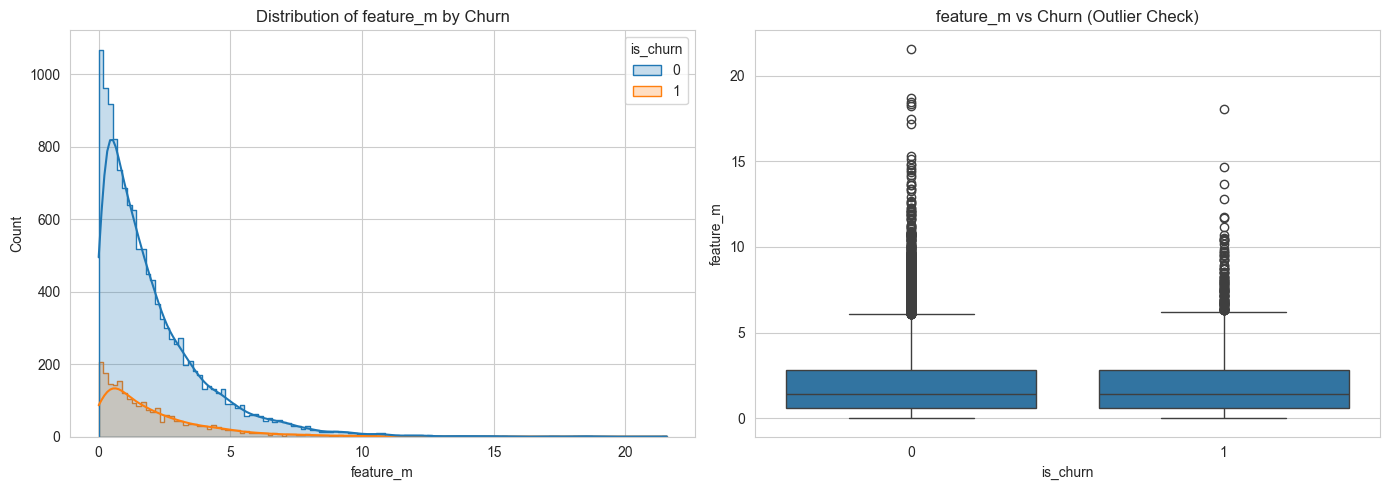

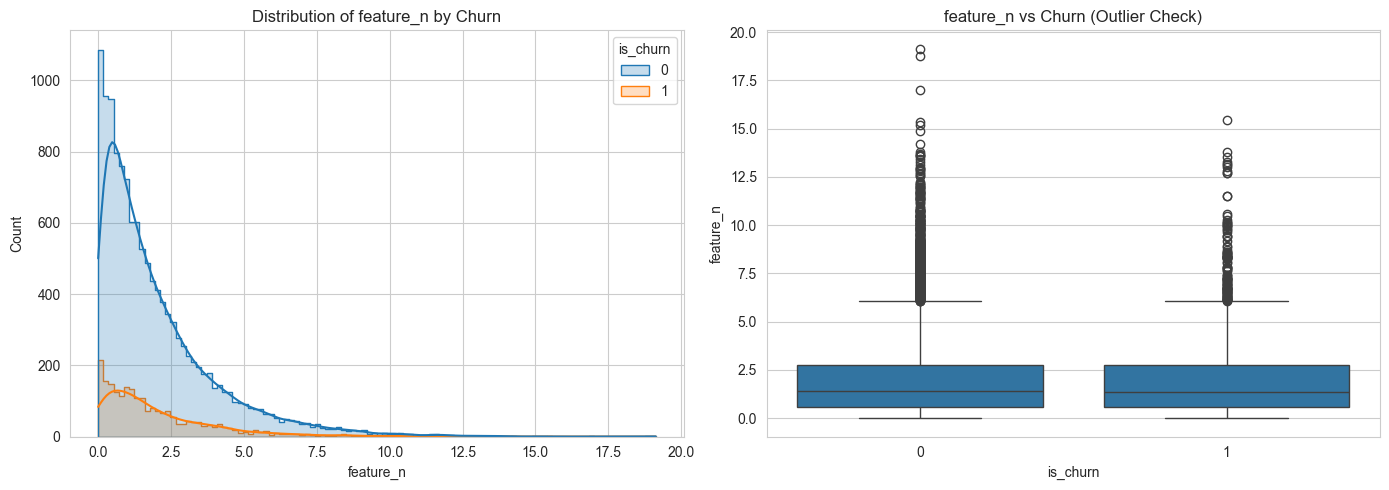

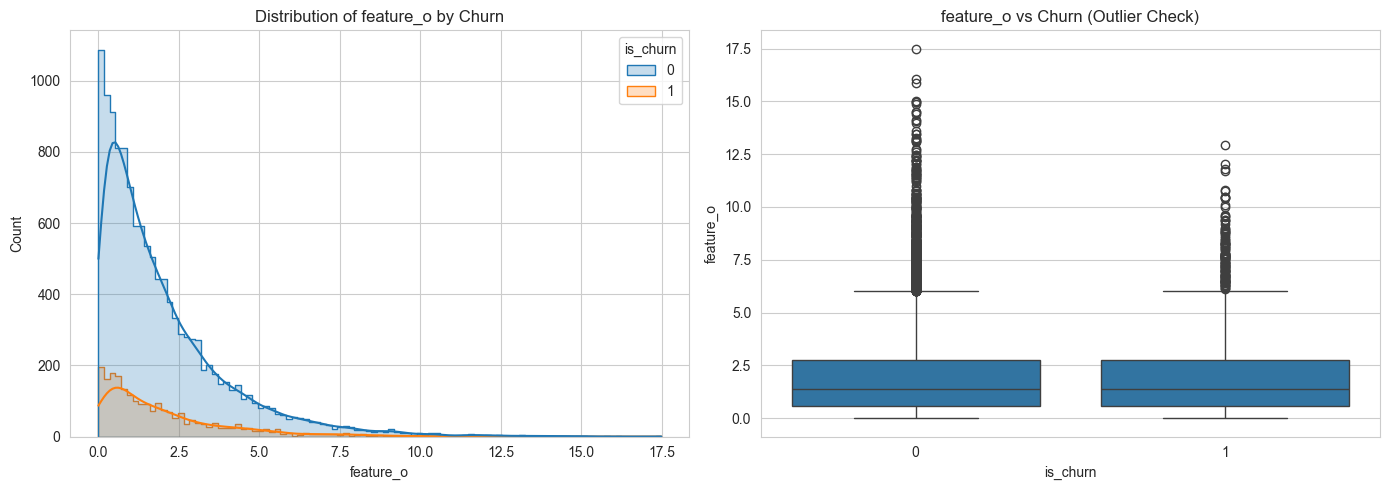

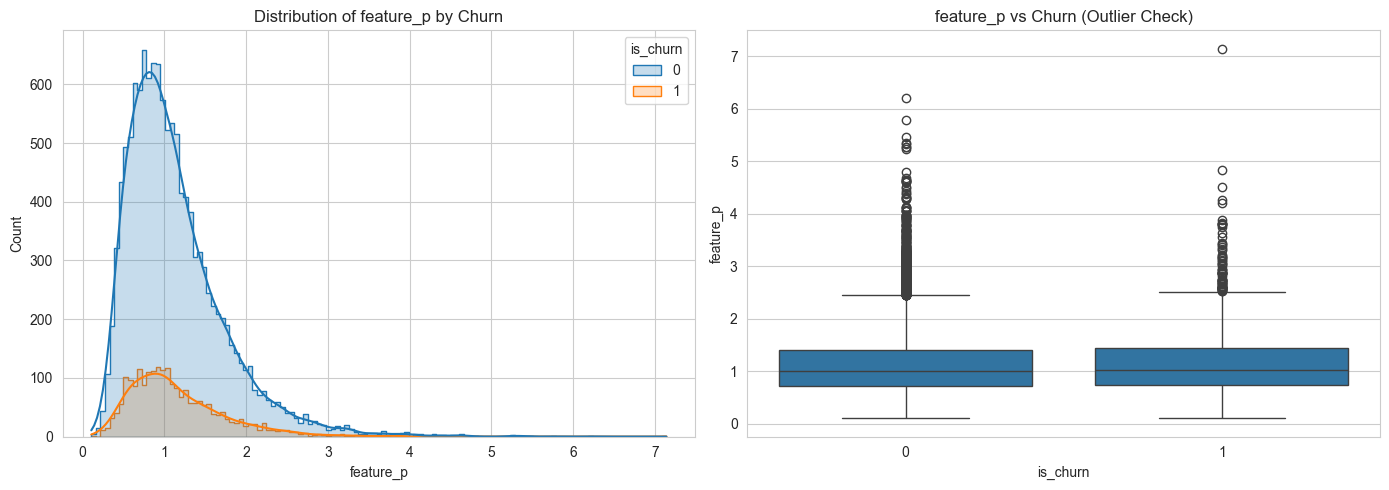

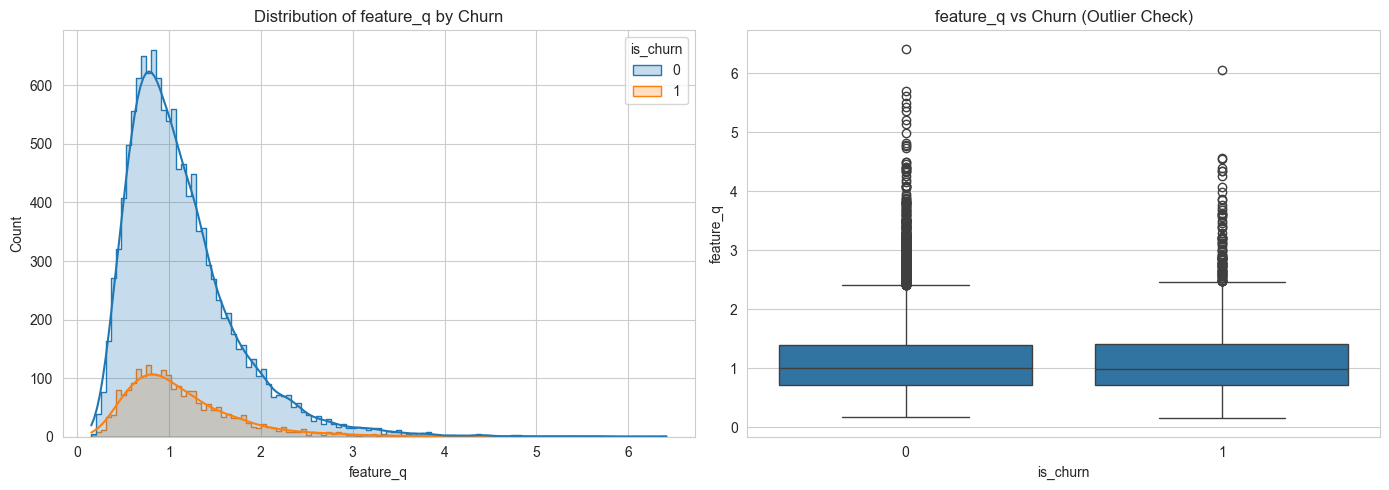

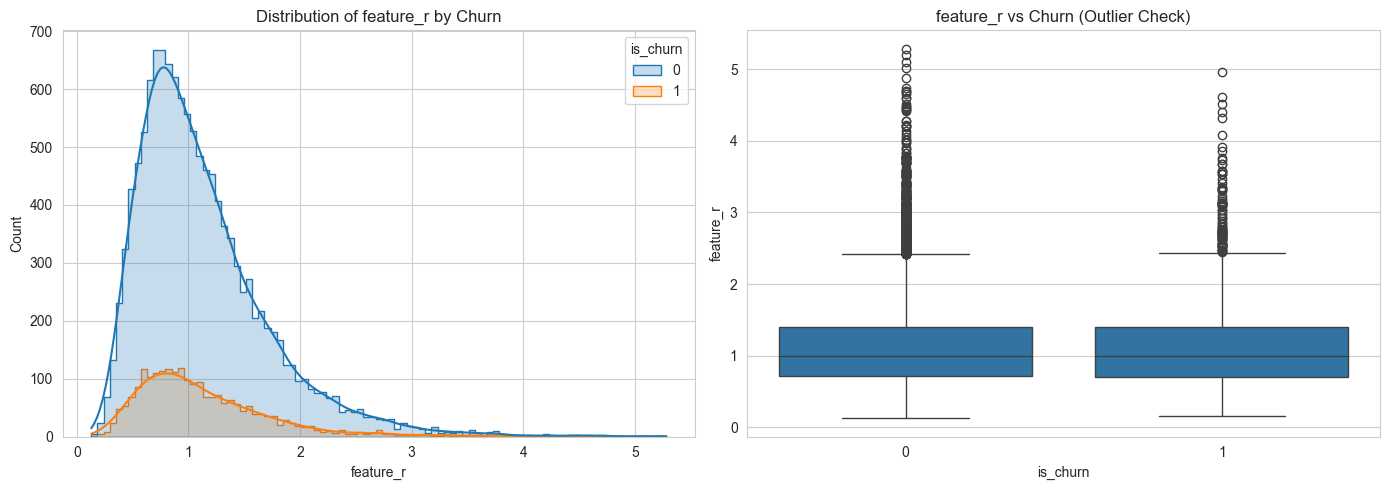

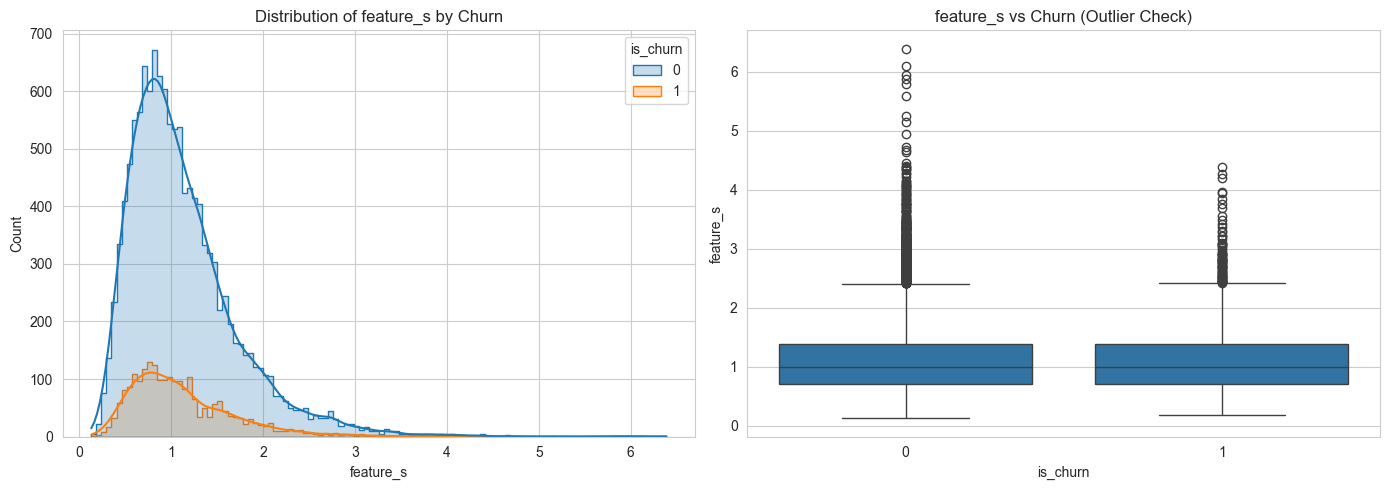

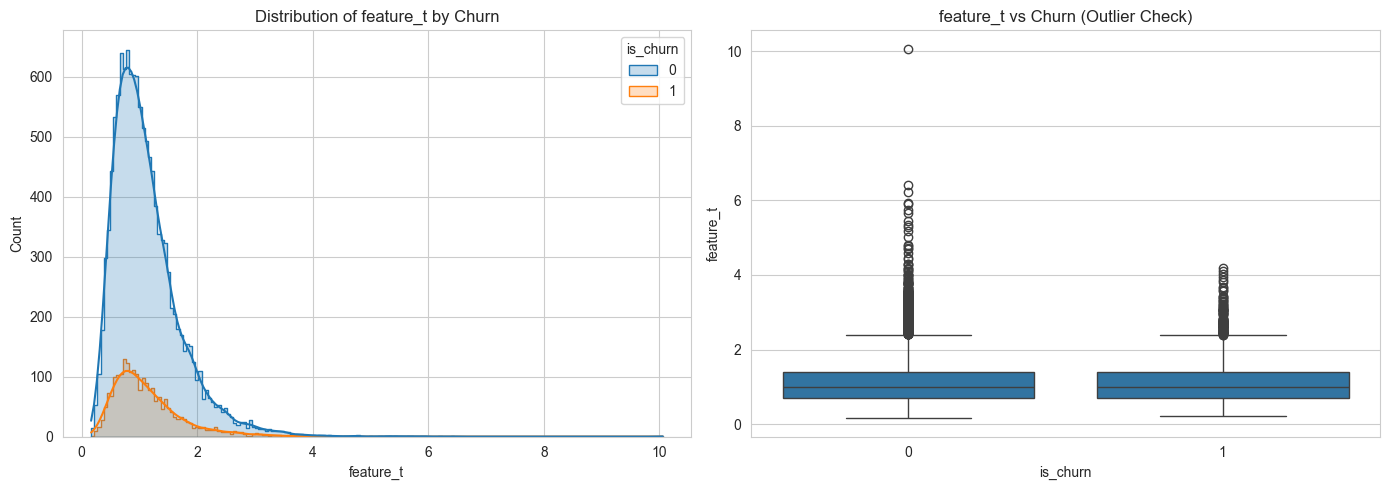

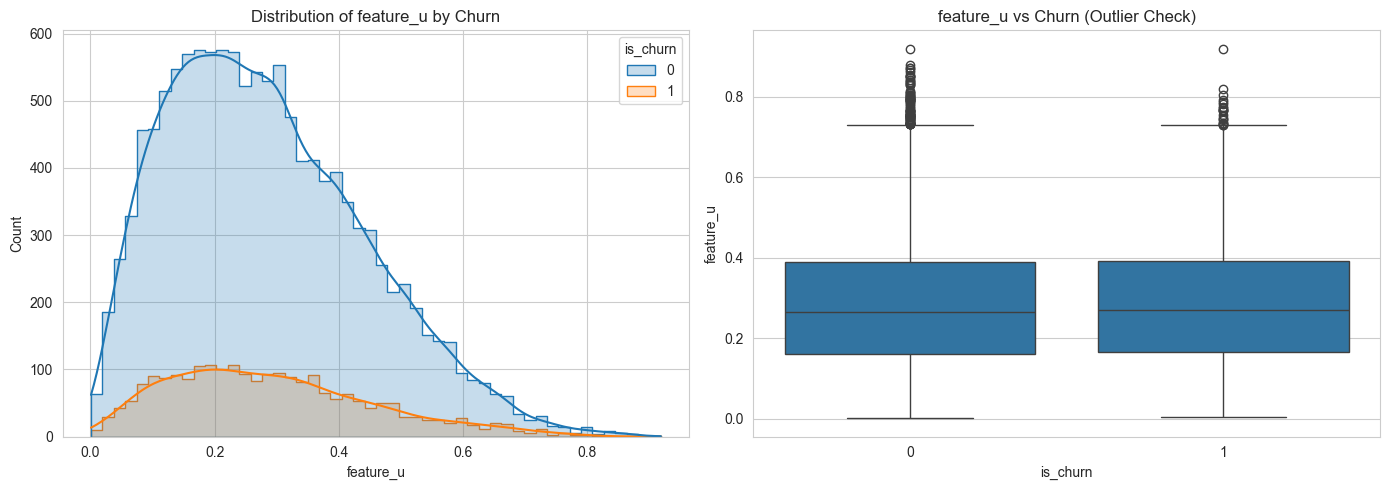

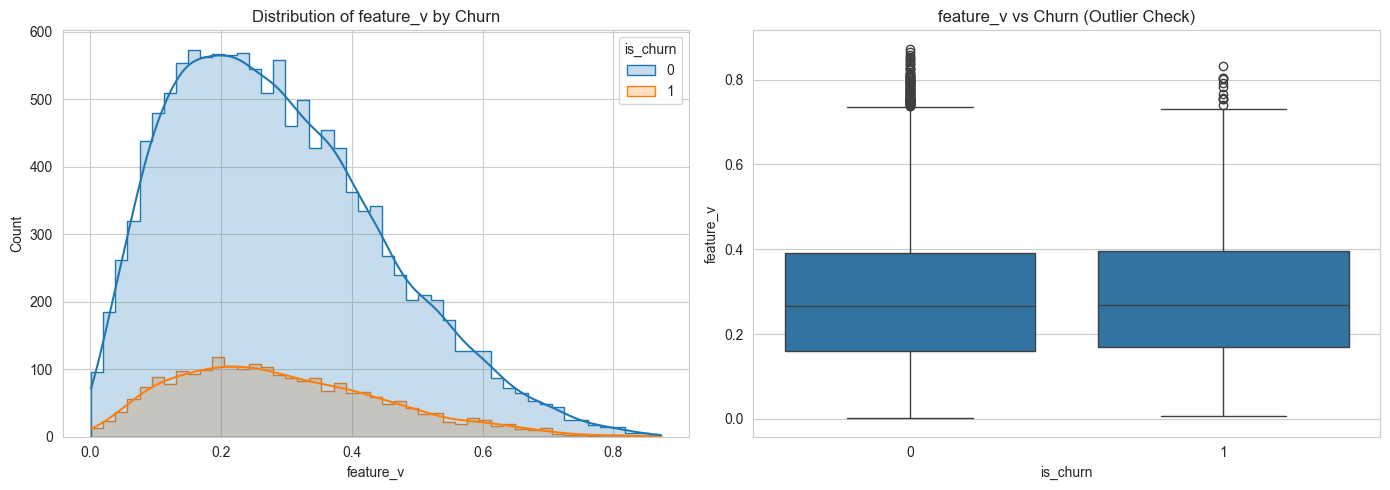

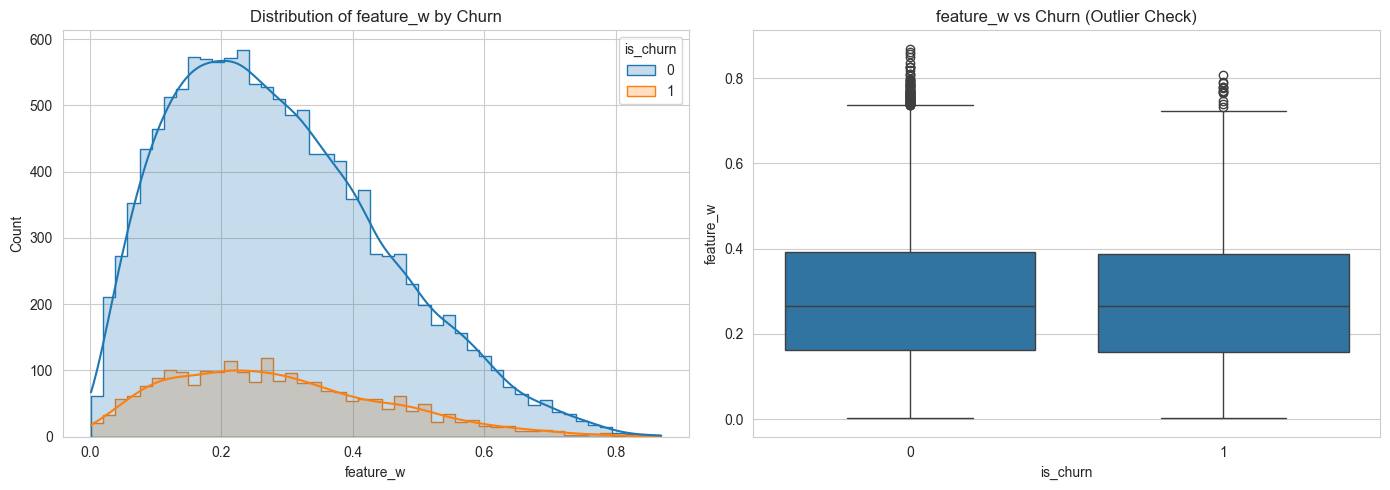

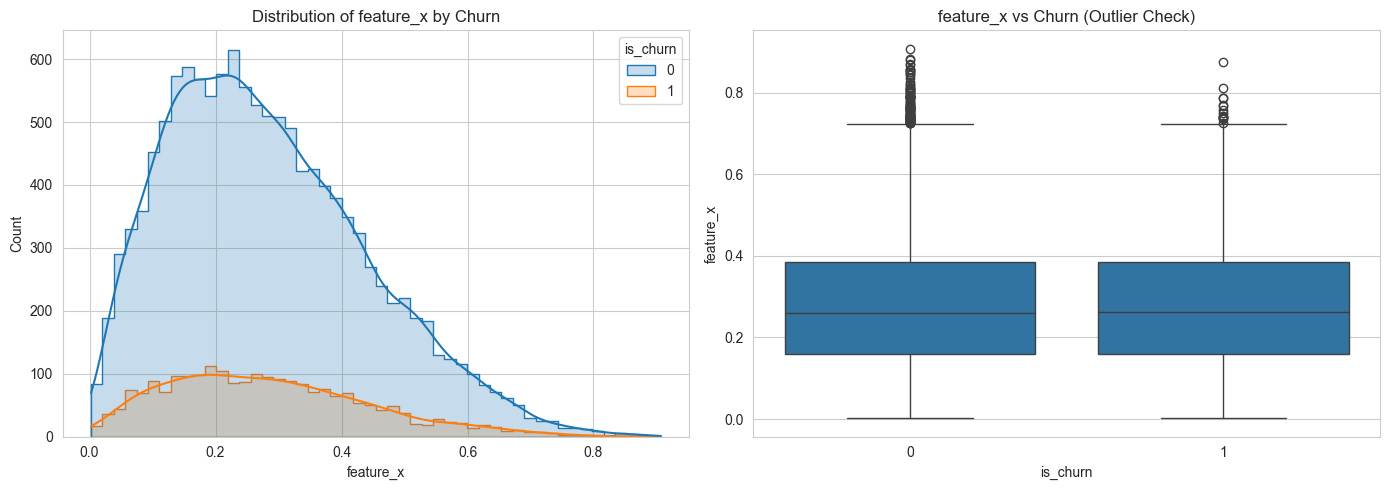

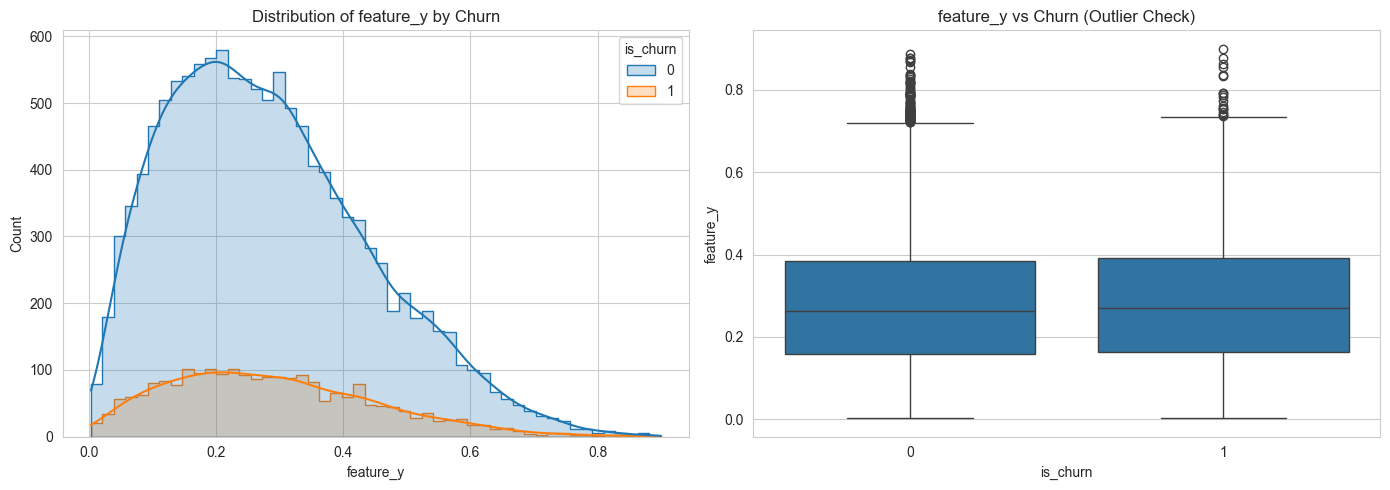

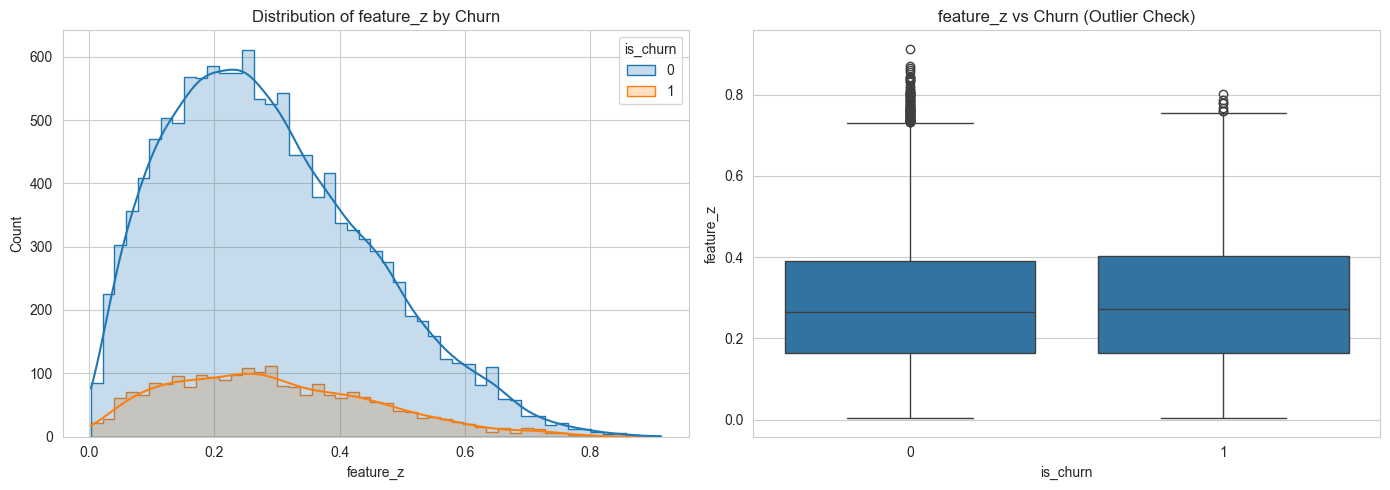

In [8]:
# 4. Analysis II - Feature Distribution
eda.analyze_numerical_features()


--- Correlation Analysis ---


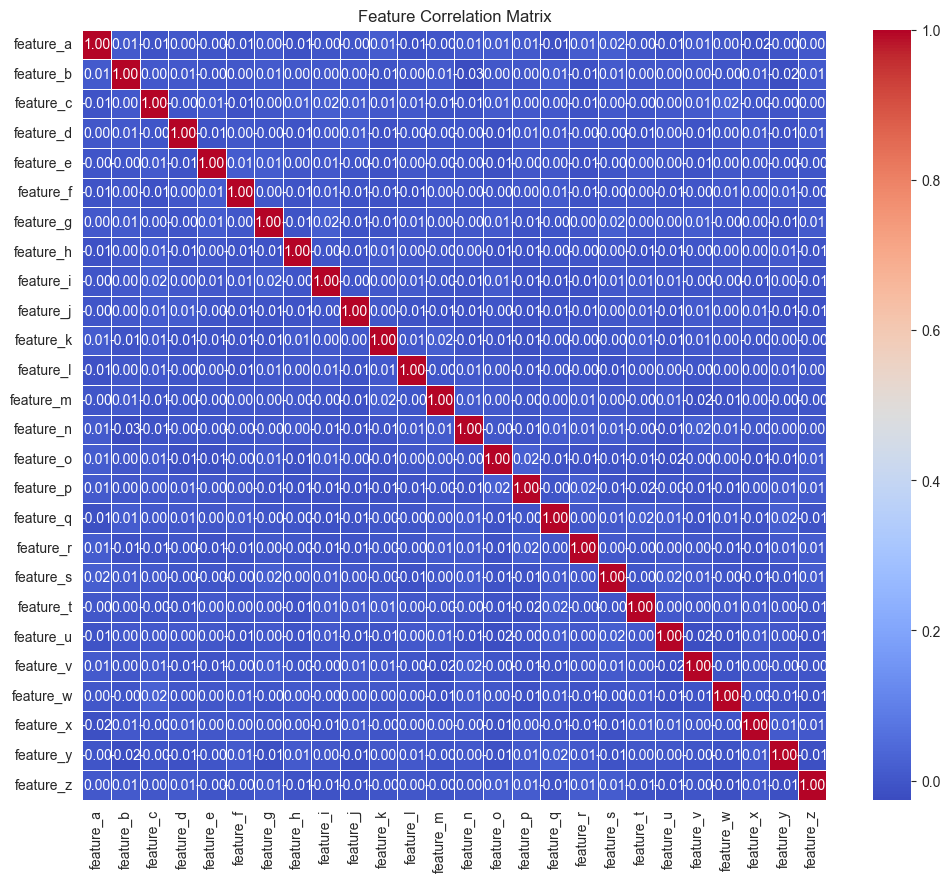

---- Feature Utility Score (Mutual Information) ----
feature_k    0.006582
feature_r    0.005660
feature_n    0.003206
feature_q    0.002836
feature_s    0.002758
feature_t    0.002730
feature_l    0.002322
feature_z    0.001378
feature_h    0.001237
feature_i    0.000000
feature_d    0.000000
feature_y    0.000000
feature_x    0.000000
feature_w    0.000000
feature_v    0.000000
feature_u    0.000000
feature_c    0.000000
feature_e    0.000000
feature_j    0.000000
feature_f    0.000000
feature_p    0.000000
feature_o    0.000000
feature_b    0.000000
feature_m    0.000000
feature_g    0.000000
feature_a    0.000000
Name: MI Score, dtype: float64


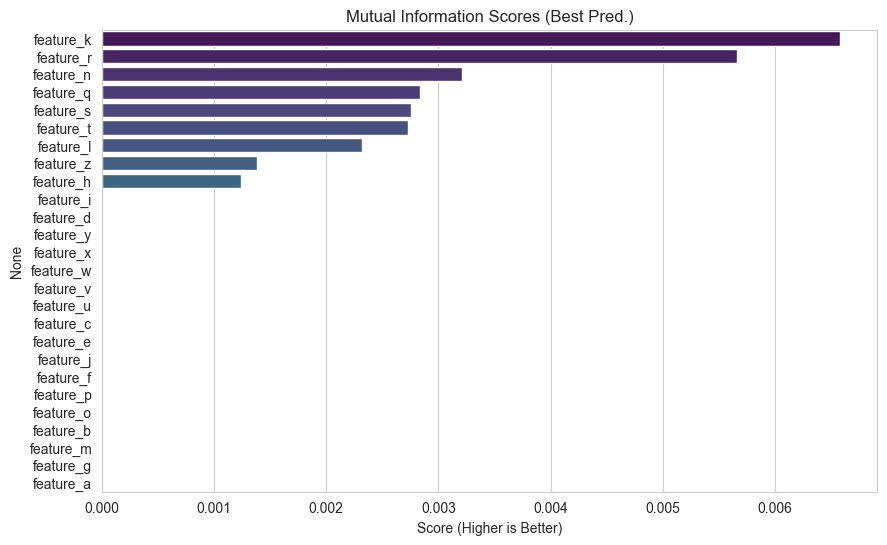

feature_k    0.006582
feature_r    0.005660
feature_n    0.003206
feature_q    0.002836
feature_s    0.002758
feature_t    0.002730
feature_l    0.002322
feature_z    0.001378
feature_h    0.001237
feature_i    0.000000
feature_d    0.000000
feature_y    0.000000
feature_x    0.000000
feature_w    0.000000
feature_v    0.000000
feature_u    0.000000
feature_c    0.000000
feature_e    0.000000
feature_j    0.000000
feature_f    0.000000
feature_p    0.000000
feature_o    0.000000
feature_b    0.000000
feature_m    0.000000
feature_g    0.000000
feature_a    0.000000
Name: MI Score, dtype: float64

In [9]:
# 4. Analysis III - Correlation and MI Score
eda.correlation_analysis()
eda.feature_importance()